In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, balanced_accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import os
import pickle

In [23]:
df = pd.read_csv('../../2-cleaning-EDA/data/pros.csv')

In [24]:
df.shape

(958, 48)

In [25]:
df.drop(columns = ['Unnamed: 0',
                   'mvp',
                   'taken',
                   'goals',
                   'assists',
                   'avg_distance_to_ball_possession',
                   'shots',
                   'amount_stolen'                  ],
                   inplace = True)

In [26]:
try:
    df.drop(columns = 'goals_against_while_last_defender')
except KeyError:
    pass

In [27]:
df.iloc[0, :]

saves                                         0
score                                       378
bcpm                                  420.76846
avg_amount                                48.78
amount_collected                           2338
amount_collected_big                       1535
amount_collected_small                      803
amount_overfill                             296
amount_used_while_supersonic                389
percent_zero_boost                    12.957797
percent_full_boost                    10.159272
percent_boost_0_25                    33.467205
percent_boost_25_50                   27.739504
percent_boost_50_75                   10.636721
percent_boost_75_100                  28.156569
count_powerslide                             84
avg_powerslide_duration                    0.12
avg_speed_percentage                   66.13043
percent_slow_speed                     47.60705
percent_boost_speed                   38.449085
percent_supersonic_speed              13

In [28]:
X = df.drop(columns = 'player_name')
y = df.player_name

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [9]:
y_train.value_counts(normalize = True)

Vati           0.398329
Oski           0.337047
M0nkey M00n    0.264624
Name: player_name, dtype: float64

In [29]:
ss = StandardScaler()

# X_train = pd.DataFrame(ss.fit_transform(X_train), columns = ss.get_feature_names_out())
# X_test = pd.DataFrame(ss.transform(X_test), columns = ss.get_feature_names_out())


In [13]:
et = Pipeline([
    ('ss', StandardScaler()),
    ('et', ExtraTreesClassifier())
])
et.fit(X_train, y_train)


Pipeline(steps=[('ss', StandardScaler()), ('et', ExtraTreesClassifier())])

In [14]:
et.score(X_train, y_train)

1.0

In [15]:
et.score(X_test, y_test)

0.9

In [11]:
poly = PolynomialFeatures(interaction_only=True)

In [17]:
knn = Pipeline([
    ('ss', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('knn', KNeighborsClassifier())
])

In [18]:
knn.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('poly', PolynomialFeatures()),
                ('knn', KNeighborsClassifier())])

In [19]:
knn.score(X_train, y_train)

0.883008356545961

In [20]:
knn.score(X_test, y_test)

0.8125

In [21]:
et_poly = Pipeline([
    ('ss', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('et', ExtraTreesClassifier())
])

In [22]:
et_poly.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('poly', PolynomialFeatures()),
                ('et', ExtraTreesClassifier())])

In [23]:
et.score(X_train, y_train)

1.0

In [24]:
et.score(X_test, y_test)

0.9

In [25]:
def get_accuracies(X_train, X_test, y_train, y_test, model, model_name:str, scores_df=None, norm=None, confusion = True):
    
    # Takes training and test splits, a desired model and model name (string),
    # current scoring dataframe and norm parameter for the heatmap output
    
    # Creates columns for scoring metrics on first run
    if scores_df is None:
        scores_df = pd.DataFrame(columns = ['train_acc', 'test_acc', 'bal_acc'])
    
    # fits model to training data
    model.fit(X_train, y_train)
    
    # produces a confusion matrix for the prediction and true values of the test data
    if confusion == True:
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', normalize=norm)
    
    # predicted subreddits for each row, used to calculate balanced accuracy
    preds = model.predict(X_test)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    bal_acc = balanced_accuracy_score(y_test, preds)

    # dataframe updated with model name and corresponding scores
    scores_df.loc[model_name,:] = [train_acc, test_acc, bal_acc]
    
    print(scores_df)
    
    return scores_df

In [26]:
knn_poly = Pipeline([
    ('ss', StandardScaler()),
    ('poly', PolynomialFeatures(interaction_only=True)),
    ('knn', KNeighborsClassifier())
])

In [27]:
gs_knn = GridSearchCV(
    knn_poly,
    param_grid={
        'knn__n_neighbors' : [3, 5, 7, 9, 10, 15],
        'knn__weights' : ['uniform', 'distance'],
        'knn__p' : [1, 1.5, 2]
    },
    cv = 3,
    verbose = 1,
    n_jobs = -1,
    scoring='balanced_accuracy'
)

In [28]:
gs_knn.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('poly',
                                        PolynomialFeatures(interaction_only=True)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 10, 15],
                         'knn__p': [1, 1.5, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='balanced_accuracy', verbose=1)

In [29]:
gs_knn.best_params_

{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}

    train_acc test_acc   bal_acc
knn       1.0   0.8375  0.831184


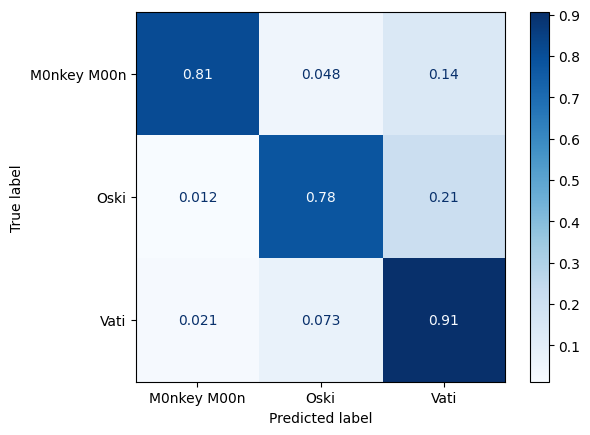

In [30]:
scores_df = get_accuracies(X_train, X_test, y_train, y_test, 
                           gs_knn.best_estimator_, 
                           'knn',
                           norm = 'true')

In [30]:
pipe_et = Pipeline([
    ('ss', StandardScaler()),
    ('poly', PolynomialFeatures(interaction_only=True)),
    ('et', ExtraTreesClassifier())
])

In [31]:
gs_et = GridSearchCV(
    pipe_et,
    param_grid={
        'et__n_estimators' : [46],
        'et__max_depth' : [5,7,10,15],
        'et__min_samples_split' : [1.0, 2,3,4]
    },
    cv = 5,
    verbose = 1,
    n_jobs = -1,
    scoring = 'balanced_accuracy'
)

In [32]:
gs_et.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('poly',
                                        PolynomialFeatures(interaction_only=True)),
                                       ('et', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid={'et__max_depth': [5, 7, 10, 15],
                         'et__min_samples_split': [1.0, 2, 3, 4],
                         'et__n_estimators': [46]},
             scoring='balanced_accuracy', verbose=1)

In [33]:
gs_et.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('poly', PolynomialFeatures(interaction_only=True)),
                ('et', ExtraTreesClassifier(max_depth=15, n_estimators=46))])

    train_acc  test_acc   bal_acc
knn       1.0    0.8375  0.831184
et        1.0  0.891667   0.88628


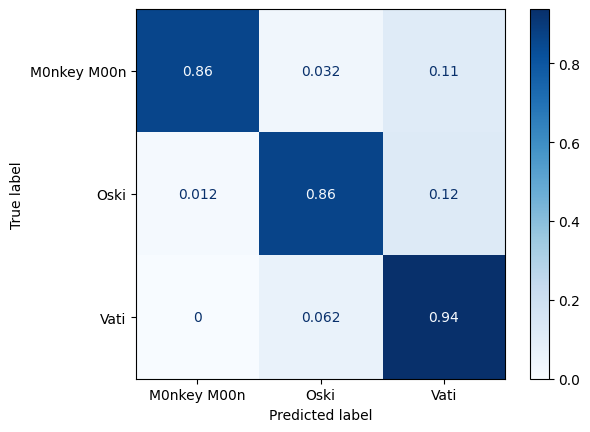

In [35]:
scores_df = get_accuracies(X_train, X_test, y_train, y_test, 
                           gs_et.best_estimator_, 
                           'et',
                           scores_df = scores_df,
                           norm = 'true')

In [40]:
gs_et.predict(df.head(10).drop(columns = 'player_name'))

array(['Oski', 'Vati', 'Oski', 'M0nkey M00n', 'Oski', 'Oski', 'Oski',
       'Oski', 'Oski', 'Oski'], dtype=object)

In [17]:
importances = gs_et.best_estimator_.named_steps['et'].feature_importances_

In [18]:
features = []
for i in range(39):
    features.append((importances[i],df.columns[i]))

In [19]:
features.sort()

In [20]:
features = features[::-1]

In [21]:
feature_importances = pd.DataFrame(features, columns = ['prediction weight', 'stat'])

In [22]:
feature_importances

,prediction weight,stat
0,0.017698,avg_powerslide_duration
1,0.016966,avg_amount
2,0.013836,count_powerslide
3,0.013378,percent_boost_0_25
4,0.011727,percent_high_air
5,0.011167,percent_boost_25_50
6,0.011141,percent_boost_speed
7,0.009534,percent_slow_speed
8,0.008508,percent_ground
9,0.008322,amount_collected


In [42]:
probabilities = pd.DataFrame(gs_et.best_estimator_.predict_proba(X_test), columns = ['MonkeyMoon', 'Oski', 'Vatira'])

In [43]:
probabilities

,MonkeyMoon,Oski,Vatira
0,0.000000,1.000000,0.000000
1,0.103935,0.044940,0.851125
2,0.956522,0.032609,0.010870
3,0.835749,0.065217,0.099034
4,0.451914,0.261398,0.286689
...,...,...,...
235,0.869565,0.054943,0.075491
236,0.928140,0.005435,0.066425
237,0.354250,0.270502,0.375249
238,0.017818,0.879659,0.102523


In [44]:
gnb = Pipeline([
    ('ss', StandardScaler()),
    ('poly', PolynomialFeatures(interaction_only=True)),
    ('gnb', GaussianNB())
])
gnb.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('poly', PolynomialFeatures(interaction_only=True)),
                ('gnb', GaussianNB())])

In [45]:
gnb.score(X_train, y_train)

0.3398328690807799

In [46]:
gnb.score(X_test, y_test)

0.2833333333333333

    train_acc  test_acc   bal_acc
knn       1.0    0.8375  0.831184
et        1.0  0.891667   0.88628
gnb  0.339833  0.283333  0.342464


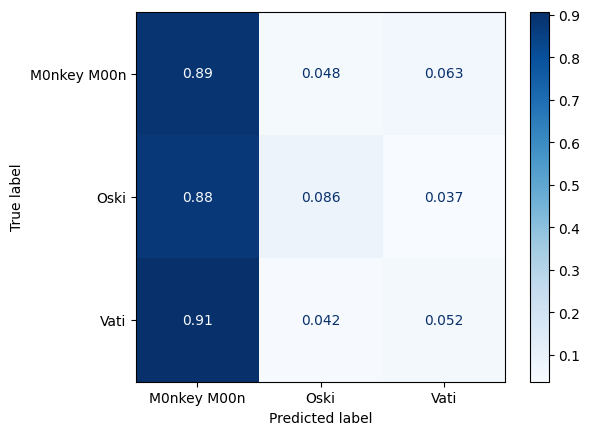

In [47]:
scores_df = get_accuracies(X_train, X_test, y_train, y_test, 
                           gnb, 
                           'gnb',
                           scores_df = scores_df,
                           norm = 'true')

In [48]:
stack = [
    ('knn', gs_knn.best_estimator_)
]

stx = StackingClassifier(
    estimators=stack,
    final_estimator=gs_et.best_estimator_
)

      train_acc  test_acc   bal_acc
knn         1.0    0.8375  0.831184
et          1.0  0.891667   0.88628
gnb    0.339833  0.283333  0.342464
stack       1.0    0.8125  0.810461


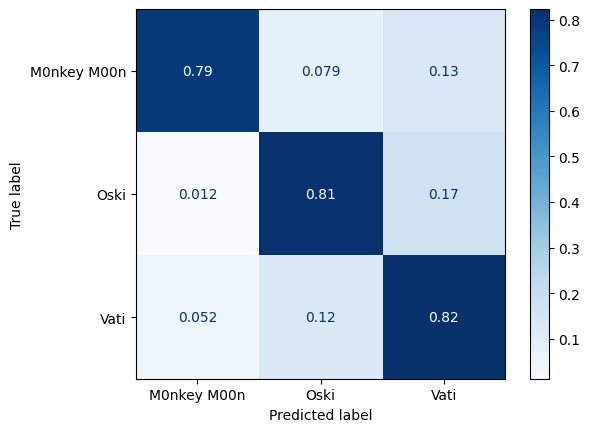

In [49]:
scores_df = get_accuracies(X_train, X_test, y_train, y_test, 
                           stx, 
                           'stack',
                           scores_df = scores_df,
                           norm = 'true')

In [50]:
nn_y = y.replace({
    'M0nkey M00n' : 0,
    'Oski' : 1,
    'Vati' : 2
})

In [51]:
nn_y.value_counts()

2    382
1    323
0    253
Name: player_name, dtype: int64

In [52]:
nn_y = to_categorical(nn_y)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, nn_y, random_state=42, stratify=y)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [54]:
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)


In [55]:
model = Sequential()

model.add(Dense(128,
                input_shape = (781,),
                activation = 'relu'
               )
         )

model.add(Dense(32,
                activation='relu'
               )
         )
model.add(Dense(3,
                activation = 'softmax'
               )
         )

In [56]:
model.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [57]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience = 5,
                           min_delta = 0.00,
                           restore_best_weights=True
                          )

In [58]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs = 150, 
          batch_size = 1024,
          callbacks = [early_stop]
                   )

Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 1.2938 - acc: 0.3691 - val_loss: 1.4612 - val_acc: 0.4167
Epoch 2/150
1/1 [==============================] - 0s 151ms/step - loss: 1.0191 - acc: 0.4652 - val_loss: 1.3398 - val_acc: 0.5583
Epoch 3/150
1/1 [==============================] - 0s 160ms/step - loss: 0.8825 - acc: 0.5836 - val_loss: 1.2718 - val_acc: 0.6625
Epoch 4/150
1/1 [==============================] - 0s 188ms/step - loss: 0.7821 - acc: 0.6894 - val_loss: 1.2134 - val_acc: 0.7208
Epoch 5/150
1/1 [==============================] - 0s 125ms/step - loss: 0.6989 - acc: 0.7632 - val_loss: 1.1707 - val_acc: 0.7542
Epoch 6/150
1/1 [==============================] - 0s 123ms/step - loss: 0.6291 - acc: 0.8231 - val_loss: 1.1415 - val_acc: 0.7875
Epoch 7/150
1/1 [==============================] - 0s 157ms/step - loss: 0.5675 - acc: 0.8552 - val_loss: 1.1217 - val_acc: 0.8167
Epoch 8/150
1/1 [==============================] - 0s 204ms/step - loss: 0.5129 - acc:

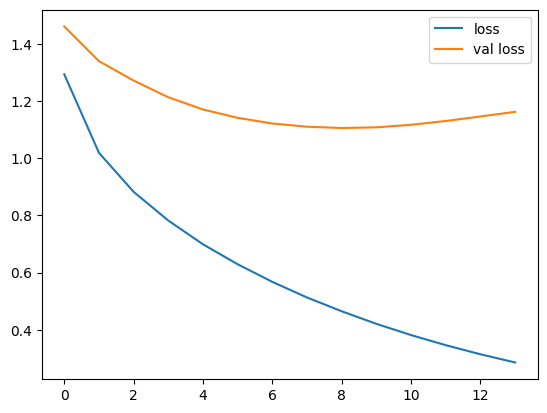

In [59]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend();

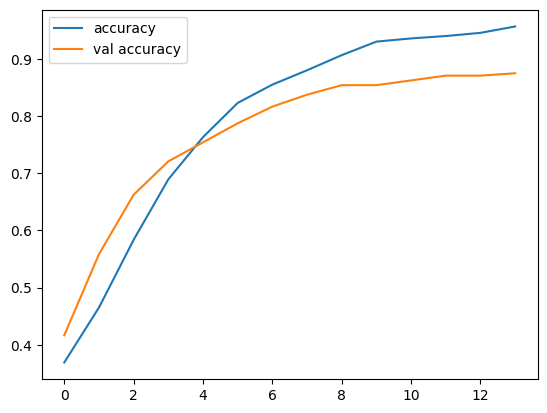

In [60]:
plt.plot(history.history['acc'], label = 'accuracy')
plt.plot(history.history['val_acc'], label = 'val accuracy')
plt.legend();

In [61]:
model.evaluate(X_test, y_test)[1]

8/8 [==============================] - 0s 6ms/step - loss: 1.1059 - acc: 0.8542


0.8541666865348816

In [62]:
nn_predictions = pd.DataFrame(model.predict(X_test), columns = ['MonkeyMoon', 'Oski', 'Vatira'])

8/8 [==============================] - 0s 6ms/step


In [63]:
nn_predictions

,MonkeyMoon,Oski,Vatira
0,0.015788,0.958469,0.025744
1,0.334949,0.249442,0.415609
2,0.520953,0.069040,0.410007
3,0.639534,0.088636,0.271830
4,0.413610,0.334955,0.251435
...,...,...,...
235,0.675259,0.030335,0.294406
236,0.469639,0.268408,0.261954
237,0.177097,0.340578,0.482325
238,0.167756,0.433642,0.398602


In [64]:
probabilities

,MonkeyMoon,Oski,Vatira
0,0.000000,1.000000,0.000000
1,0.103935,0.044940,0.851125
2,0.956522,0.032609,0.010870
3,0.835749,0.065217,0.099034
4,0.451914,0.261398,0.286689
...,...,...,...
235,0.869565,0.054943,0.075491
236,0.928140,0.005435,0.066425
237,0.354250,0.270502,0.375249
238,0.017818,0.879659,0.102523


In [65]:
with open('nn_model_ss_poly.pkl', 'wb') as picklefile:
    pickle.dump((model, ss, poly), picklefile)

In [66]:
model.save('tf_save_model_2')

INFO:tensorflow:Assets written to: tf_save_model_2/assets


INFO:tensorflow:Assets written to: tf_save_model_2/assets


In [34]:
with open('../../et_model_4.pkl', 'wb') as picklefile:
    pickle.dump(gs_et.best_estimator_, picklefile)

In [68]:
boay = pd.read_csv('../data/boay_.csv')

In [69]:
boay_preds = pd.DataFrame(model.predict(poly.transform(ss.transform(boay.drop(columns = ['Unnamed: 0','player_name']))),
                                             ), columns = ['MonkeyMoon', 'Oski', 'Vatira'])

1/1 [==============================] - 0s 31ms/step


In [70]:
boay_preds.mean()

MonkeyMoon    0.354896
Oski          0.301968
Vatira        0.343137
dtype: float32

In [71]:
with open('nn_model_ss_poly.pkl', 'rb') as picklefile:
    model_open, ss_open, poly_open = pickle.load(picklefile)

In [72]:
pd.DataFrame(model_open.predict(poly.transform(ss.transform(boay.drop(columns = ['Unnamed: 0', 'player_name'])))), columns = ['MM', 'Oski', 'Vati'])

1/1 [==============================] - 0s 135ms/step


,MM,Oski,Vati
0,0.206119,0.174215,0.619666
1,0.206176,0.179022,0.614802
2,0.225842,0.148270,0.625887
3,0.276819,0.499077,0.224103
4,0.143571,0.268621,0.587808
5,0.143646,0.262185,0.594168
6,0.416183,0.417904,0.165913
7,0.282118,0.063948,0.653934
8,0.228645,0.372959,0.398396
9,0.575587,0.261287,0.163127
